# Matrix Factorization train/test split
- Team 메로나 김태윤

In [1]:
import os
import numpy as np
import pandas as pd

In [2]:
u_data_src = os.path.join('u.data')
r_cols = ['user_id', 'movie_id', 'rating', 'timestampe']
ratings = pd.read_csv(u_data_src,
                     sep='\t',
                     names = r_cols,
                     encoding='latin-1')

# timestampe 제거
ratings = ratings[['user_id', 'movie_id', 'rating']].astype(int)

#### sklearn을 통한 test/test 나누기
- train_size = 0.75(test_size = 0.25)
- cutoff를 통해 train_size에 맞춰서 ratings을 자름
- ratings_train = ratings.iloc[ : cutoff]  =>> 1 ~ (cutoff - 1) 까지 train
- ratings_test = ratings.iloc[cutoff : ]  =>> cutoff ~  까지 test

##### .iloc 메서드
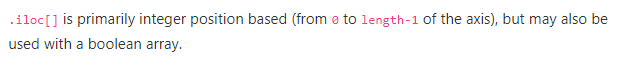

In [3]:
from sklearn.utils import shuffle

# train 75% test 25%
TRAIN_SIZE = 0.75
# random_state는 seed 비슷한 것
# 사용자 - 영화 - 평점
ratings = shuffle(ratings, random_state = 2021)
cutoff = int(TRAIN_SIZE * len(ratings))
ratings_train = ratings.iloc[ : cutoff]
ratings_test = ratings.iloc[cutoff : ]


## 전체 코드

In [13]:
class NEW_MF():
    def __init__(self, ratings, hyper_params):
        self.R = np.array(ratings)
        self.num_users, self.num_items = np.shape(self.R)
        self.K = hyper_params['K']
        self.alpha = hyper_params['alpha']
        self.beta = hyper_params['beta']
        self.iterations = hyper_params['iterations']
        self.verbose = hyper_params['verbose']
        
        # 데이터가 연속값이 아닐 때 (탈퇴, 휴먼계정)
        # 비어있는 값, 
        item_id_index = []
        index_item_id = []
        
        for i,one_id in enumerate(ratings.T):
            item_id_index.append([one_id, i])
            index_item_id.append([i, one_id])
        self.item_id_index = dict(item_id_index)
        self.index_item_id = dict(index_item_id)
        
        user_id_index = []
        index_user_id = []
        for i,one_id in enumerate(ratings.T):
            user_id_index.append([one_id, i])
            index_user_id.append([i, one_id])
        self.user_id_index = dict(user_id_index)
        self.index_user_id = dict(index_user_id)
        
    def rmse(self):
        xs, ys = self.R.nonzero()
        self.predictions = []
        self.errors = []
        
        for x,y in zip(xs, ys):
            prediction = self.get_prediction(x,y)
            self.predictions.append(prediction)
            self.errors.append(self.R[x,y] - prediction)
        
        self.predictions = np.array(self.predictions)
        self.errors = np.array(self.errors)
        
        return np.sqrt(np.mean(self.errors**2))
    
    
    def get_prediction(self,i,j):
        prediction = self.b + self.b_u[i] + self.b_d[j] + self.P[i,:].dot(self.Q[j,].T)
        return prediction
    
    #Test set 선정
    def set_test(self, ratings_test):
        test_set = []
        for i in range(len(ratings_test)):
            x = self.user_id_index[ratings_test.iloc[i, 0]]
            y = self.item_id_index[ratings_test.iloc[i, 0]]
            z = ratings_test.iloc[i,2]
            test_set.append([x,y,z])
            self.R[x,y] = 0
        self.test_set = test_set
        return test_set
    
    #test set rmse 계산
    def test_rmse(self):
        error = 0
        for one_set in self.test_set:
            #유저아이디, 아이템아이디
            predicted = self.get_prediction(one_set[0], one_set[1])
            # e => e^2
            error += pow(one_set[2] - predicted, 2)
        return np.sqrt(error/len(self.test_set))
    
    def test(self):
        self.P = np.random.normal(scale=1./self.K,
                                 size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K,
                                 size=(self.num_items, self.K))
        self.b_u = np.zeros(self.num_users)
        self.b_d = np.zeros(self.num_items)
        self.b = np.mean(self.R[self.R.nonzero()])
        
        rows, columns = self.R.nonzero()
        self.samples = [(i,j,self.R[i,j]) for i,j in zip(rows, columns)]
        
        training_process = []
        
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            rmse1 = self.rmse()
            rmse2 = self.test_rmse()
            training_process.append((i+1, rmse1, rmse2))
            if self.verbose:
                if(i+1) % 10 == 0:
                    print('Iteration : %d ;test RMSE %.4f ; '%(i+1, rmse1))
    
    def get_one_prediction(self, user_id, item_id):
        return self.get_prediction(self.user_id_index[user_id], 
                                   self.item_id_index[item_id])
    def full_prediction(self):
        return self.b + self.b_u[:, np.newaxis] + self.b_d[np.newaxis, :] + self.P.dot(self.Q.T)
    
    def sgd(self):
        for i, j, r in self.samples:
            prediction = self.get_prediction(i, j)
            
            e = (r-prediction)
            
            self.b_u[i] += self.alpha * (e - (self.beta * self.b_u[i]))
            self.b_d[j] += self.alpha * (e - (self.beta * self.b_d[i]))
            
            self.P[i, :] += self.alpha * ((e * self.Q[j, :]) - (self.beta * self.P[i, :]))
            self.P[i, :] += self.alpha * ((e * self.P[i, :]) - (self.beta * self.Q[j, :]))
    
R_temp = ratings.pivot(index = 'user_id',
                          columns = 'movie_id',
                          values='rating').fillna(0)
    
hyper_params = {   
    'K' : 30,
    'alpha' : 0.001,
    'beta' : 0.02,
    'iterations' : 100,
    'verbose' : True
}
    
mf = NEW_MF(R_temp, hyper_params)
test_set = mf.set_test(ratings_test)
result = mf.test()
            



Iteration : 10 ;test RMSE 0.9585 ; 
Iteration : 20 ;test RMSE 0.9376 ; 
Iteration : 30 ;test RMSE 0.9288 ; 
Iteration : 40 ;test RMSE 0.9239 ; 
Iteration : 50 ;test RMSE 0.9209 ; 
Iteration : 60 ;test RMSE 0.9188 ; 
Iteration : 70 ;test RMSE 0.9174 ; 
Iteration : 80 ;test RMSE 0.9162 ; 
Iteration : 90 ;test RMSE 0.9154 ; 
Iteration : 100 ;test RMSE 0.9147 ; 


#### def __init__(self, ratings, hyper_params):
- 사용자가 탈퇴, 휴먼계정 등의 이유로 결측치(연속값이 아닐)가 있을 수 있음.
- 이런 경우 self.R을 np.array로 변환할 경우 비어있는 아이디 때문에 index가 일치하지 않아 문제가 발생할 수 있음
- item_id와 user_id를 mapping하는 과정

In [ ]:
    def __init__(self, ratings, hyper_params):
        self.R = np.array(ratings)
        self.num_users, self.num_items = np.shape(self.R)
        self.K = hyper_params['K']
        self.alpha = hyper_params['alpha']
        self.beta = hyper_params['beta']
        self.iterations = hyper_params['iterations']
        self.verbose = hyper_params['verbose']
        
        # 데이터가 연속값이 아닐 때 (탈퇴, 휴먼계정)
        # 비어있는 값, 
        item_id_index = []
        index_item_id = []
        
        for i,one_id in enumerate(ratings.T):
            item_id_index.append([one_id, i])
            index_item_id.append([i, one_id])
        self.item_id_index = dict(item_id_index)
        self.index_item_id = dict(index_item_id)
        
        user_id_index = []
        index_user_id = []
        for i,one_id in enumerate(ratings.T):
            user_id_index.append([one_id, i])
            index_user_id.append([i, one_id])
        self.user_id_index = dict(user_id_index)
        self.index_user_id = dict(index_user_id)

#### def set_test(self, ratings_test):
- 분리된 test set을 넘겨받아 test set을 선정하는 과정

In [ ]:
    def set_test(self, ratings_test):
        test_set = []
        for i in range(len(ratings_test)):
            x = self.user_id_index[ratings_test.iloc[i, 0]]
            y = self.item_id_index[ratings_test.iloc[i, 1]]
            z = ratings_test.iloc[i,2]
            test_set.append([x,y,z])
            self.R[x,y] = 0
        self.test_set = test_set
        return test_set

#### def test_rmse(self):
- test set의 rmse를 계산하는 과정
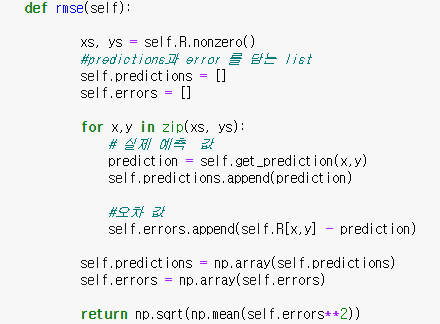
- 위 방법과 약간 다른데 제곱하는 과정을 pow로 바꾼 것
- mean => len(self.test_set)

In [ ]:
    def test_rmse(self):
        error = 0
        for one_set in self.test_set:
            #유저아이디, 아이템아이디
            predicted = self.get_prediction(one_set[0], one_set[1])
            # e => e^2
            error += pow(one_set[2] - predicted, 2)
        return np.sqrt(error/len(self.test_set))

#### 예측
- def get_one_prediction(self, user_id, item_id):
- # 사용자 1의 item_id 2번의 대한 예측


In [16]:
# 사용자 1의 item_id 2번의 대한 예측
print(mf.get_one_prediction(1,2))
print(mf.full_prediction())

[[3.89398144 3.29873781 3.09080475 ... 3.32218825 3.44825209 3.4147956 ]
 [3.94667732 3.34616146 3.14799564 ... 3.36982645 3.50362613 3.46134037]
 [3.35941666 2.78468568 2.56501681 ... 2.80331463 2.94653297 2.89061232]
 ...
 [4.21429434 3.62644756 3.41199971 ... 3.65149315 3.7695324  3.73126183]
 [4.3441877  3.75136618 3.54034578 ... 3.78296601 3.89588789 3.86082213]
 [3.82173833 3.22364512 3.01517653 ... 3.24321337 3.36556771 3.33443302]]
